# 비트코인 트레이딩 전략 - 딥러닝 모델 개발 과제 💰

**학생 정보**
- 이름: 김석진
- 학번: 202100707
- 제출일:

---

## 📋 과제 목표

**가격 변화 방향을 예측하는 딥러닝 모델과 트레이딩 전략을 개발하여 Buy and Hold 벤치마크를 초과하는 수익률을 달성하세요!**

### 과제 요구사항

1. **딥러닝 모델 개발** (핵심)
   - 가격 상승(1) / 하락(0)을 예측하는 2-class 분류 모델
   - PyTorch 사용
   - 실습에서 배운 피처 엔지니어링 활용

2. **트레이딩 전략 개발** (핵심)
   - 예측 확률을 활용한 포지션 크기 조절
   - 예: 상승 확률 60% → 자본의 60% 투자
   - 또는 자신만의 전략 개발

3. **트레이딩 시뮬레이션** (제공됨)
   - 초기 자본: $10,000
   - 거래 수수료: 0.1%
   - 자동 평가 및 시각화

### 평가 기준

- **수익률** (60%)
  - Buy and Hold 대비 초과 수익
  - 최종 자산 가치

- **모델 & 전략 설계** (30%)
  - 모델 아키텍처 선택 이유
  - 트레이딩 전략 논리성
  - 하이퍼파라미터 설명

- **코드 품질** (10%)
  - 코드 가독성
  - 주석 및 설명

---

## 1. 환경 설정 및 데이터 로딩

실습 노트북과 동일한 데이터 및 피처를 사용합니다!

In [1]:
# ========================================
# 🚀 Google Colab 사용자를 위한 설정
# ========================================
# Colab에서 실행하는 경우 이 셀을 실행하세요!

# 1. 필요한 패키지 설치
!pip install yfinance scikit-learn torch seaborn -q

# 2. utils.py 다운로드 (GitHub 저장소에서)
!wget https://raw.githubusercontent.com/ksj41165-ops/TimeSeriesForecastingTest/main/utils.py -q

# 3. utils.py가 정상적으로 다운로드되었는지 확인
import os
if os.path.exists('utils.py'):
    print("✅ utils.py 다운로드 완료!")
else:
    print("❌ utils.py 다운로드 실패. 다시 시도하거나 수동으로 업로드하세요.")

# ========================================
# 로컬 환경에서 실행하는 경우:
# - 이 셀을 건너뛰고 다음 셀부터 실행하세요
# - utils.py가 같은 폴더에 있으면 자동으로 불러옵니다
# ========================================

✅ utils.py 다운로드 완료!


In [2]:
# 필요한 라이브러리 임포트
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# 실습 노트북과 동일한 유틸리티 함수 사용
from utils import (
    load_bitcoin_data,
    create_features,
    prepare_data,
    evaluate_model,
    plot_confusion_matrix,
    device
)

# 영문 폰트 설정 (시각화용)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print("✅ 라이브러리 로딩 완료!")
print(f"Using device: {device}")

Using device: cuda
GPU: Tesla T4
✅ 라이브러리 로딩 완료!
Using device: cuda


In [36]:
# 데이터 로딩 및 피처 생성 (실습과 동일)
start_date = "2020-01-01"
end_date = datetime.now().strftime("%Y-%m-%d")

btc_data = load_bitcoin_data(start_date=start_date, end_date=end_date)
btc_features = create_features(btc_data, lookback_days=10)

print(f"\n데이터 shape: {btc_features.shape}")
print(f"생성된 특성 수: {len([c for c in btc_features.columns if c not in ['Target', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']])}")
print(f"\n주요 특성:")
print("- 이동평균 (MA_5, MA_10, MA_20, MA_50)")
print("- 변동성 (Volatility_5, Volatility_10, Volatility_20)")
print("- RSI, MACD")
print("- 과거 수익률 (Returns_Lag_1 ~ Returns_Lag_10)")

[*********************100%***********************]  1 of 1 completed

비트코인 데이터 다운로드 중: 2020-01-01 ~ 2025-12-07
다운로드 완료: 2167 행

데이터 shape: (2167, 35)
생성된 특성 수: 29

주요 특성:
- 이동평균 (MA_5, MA_10, MA_20, MA_50)
- 변동성 (Volatility_5, Volatility_10, Volatility_20)
- RSI, MACD
- 과거 수익률 (Returns_Lag_1 ~ Returns_Lag_10)


In [49]:
# 데이터 분할 및 정규화 (실습과 동일)
X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(
    btc_features, test_size=0.2, validation_size=0.1
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"학습: {len(X_train)}, 검증: {len(X_val)}, 테스트: {len(X_test)}")

학습 데이터: 1482 샘플
검증 데이터: 211 샘플
테스트 데이터: 425 샘플
학습: 1482, 검증: 211, 테스트: 425


In [26]:
# 시퀀스 데이터 생성 (딥러닝용)
sequence_length = 30

def create_sequences(X, y, seq_len=30):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len])
    return np.array(X_seq), np.array(y_seq)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train.values, sequence_length)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val.values, sequence_length)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test.values, sequence_length)

print(f"시퀀스 데이터 shape: {X_train_seq.shape}")
print(f"  - 샘플 수: {X_train_seq.shape[0]}")
print(f"  - 시퀀스 길이: {X_train_seq.shape[1]}")
print(f"  - 특성 수: {X_train_seq.shape[2]}")

시퀀스 데이터 shape: (1452, 30, 29)
  - 샘플 수: 1452
  - 시퀀스 길이: 30
  - 특성 수: 29


In [6]:
# DataLoader 생성
train_dataset = TensorDataset(
    torch.FloatTensor(X_train_seq),
    torch.FloatTensor(y_train_seq)
)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(
    torch.FloatTensor(X_val_seq),
    torch.FloatTensor(y_val_seq)
)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_dataset = TensorDataset(
    torch.FloatTensor(X_test_seq),
    torch.FloatTensor(y_test_seq)
)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("✅ DataLoader 생성 완료!")

✅ DataLoader 생성 완료!


## 2. 예제: LSTM 모델 + 확률 기반 포지션 조절 전략

이 예제는 2가지 핵심 요소로 구성됩니다:

1. **예측 모델**: 가격 상승/하락을 예측하고 확률 제공
2. **트레이딩 전략**: 예측 확률에 따라 투자 비율 조절

### 전략 예시
- 상승 확률 90% → 자본의 90% 투자
- 상승 확률 60% → 자본의 60% 투자
- 상승 확률 40% → 투자하지 않음 (현금 보유)

In [9]:
# 예제 모델: LSTM 기반 2-class 분류기
class ExampleLSTMModel(nn.Module):
    """
    예제: LSTM 기반 가격 방향 예측 모델
    출력: 상승 확률 (0~1)
    """
    def __init__(self, input_size, hidden_size=64, dropout=0.2):
        super(ExampleLSTMModel, self).__init__()

        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=1)
        self.dropout1 = nn.Dropout(dropout)
        self.bn1 = nn.BatchNorm1d(hidden_size)

        self.lstm2 = nn.LSTM(hidden_size, hidden_size//2, batch_first=True, num_layers=1)
        self.dropout2 = nn.Dropout(dropout)
        self.bn2 = nn.BatchNorm1d(hidden_size//2)

        self.fc1 = nn.Linear(hidden_size//2, 16)
        self.relu = nn.ReLU()
        self.dropout3 = nn.Dropout(dropout)

        self.fc2 = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        lstm_out, _ = self.lstm1(x)
        lstm_out = self.dropout1(lstm_out)
        lstm_out = lstm_out.permute(0, 2, 1)
        lstm_out = self.bn1(lstm_out)
        lstm_out = lstm_out.permute(0, 2, 1)

        lstm_out, _ = self.lstm2(lstm_out)
        lstm_out = self.dropout2(lstm_out[:, -1, :])
        lstm_out = self.bn2(lstm_out)

        out = self.fc1(lstm_out)
        out = self.relu(out)
        out = self.dropout3(out)

        out = self.fc2(out)
        out = self.sigmoid(out)

        return out

# 예제 모델 생성
example_model = ExampleLSTMModel(
    input_size=X_train_seq.shape[2],
    hidden_size=64,
    dropout=0.2
).to(device)

print("예제 모델 구조:")
print(example_model)
print(f"\nTotal parameters: {sum(p.numel() for p in example_model.parameters()):,}")

예제 모델 구조:
ExampleLSTMModel(
  (lstm1): LSTM(29, 64, batch_first=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm2): LSTM(64, 32, batch_first=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=32, out_features=16, bias=True)
  (relu): ReLU()
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Total parameters: 37,601


In [8]:
# 예제 모델: GRU 기반 2-class 분류기
class GRUModel(nn.Module):
    """
    예제: GRU 기반 가격 방향 예측 모델
    출력: 상승 확률 (0~1)
    """
    def __init__(self, input_size, hidden_size=64, dropout=0.2):
        super(GRUModel, self).__init__()

        self.gru1 = nn.GRU(input_size, hidden_size, batch_first=True, num_layers=1)
        self.dropout1 = nn.Dropout(dropout)
        self.bn1 = nn.BatchNorm1d(hidden_size)

        self.gru2 = nn.GRU(hidden_size, hidden_size//2, batch_first=True, num_layers=1)
        self.dropout2 = nn.Dropout(dropout)
        self.bn2 = nn.BatchNorm1d(hidden_size//2)

        self.fc1 = nn.Linear(hidden_size//2, 16)
        self.relu = nn.ReLU()
        self.dropout3 = nn.Dropout(dropout)

        self.fc2 = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x shape: (batch, seq_len, input_size)
        gru_out, _ = self.gru1(x)
        gru_out = self.dropout1(gru_out)
        # BatchNorm: (batch, features, seq_len)
        gru_out = gru_out.permute(0, 2, 1)
        gru_out = self.bn1(gru_out)
        gru_out = gru_out.permute(0, 2, 1)

        gru_out, _ = self.gru2(gru_out)
        gru_out = self.dropout2(gru_out[:, -1, :])  # Take last output
        gru_out = self.bn2(gru_out)

        out = self.fc1(gru_out)
        out = self.relu(out)
        out = self.dropout3(out)

        out = self.fc2(out)
        out = self.sigmoid(out)

        return out

# 예제 모델 생성
gru_model = GRUModel(
    input_size=X_train_seq.shape[2],
    hidden_size=64,
    dropout=0.2
).to(device)

print("예제 모델 구조:")
print(gru_model)
print(f"\nTotal parameters: {sum(p.numel() for p in gru_model.parameters()):,}")

예제 모델 구조:
GRUModel(
  (gru1): GRU(29, 64, batch_first=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gru2): GRU(64, 32, batch_first=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=32, out_features=16, bias=True)
  (relu): ReLU()
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Total parameters: 28,385


In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AttentionLayer(nn.Module):
    def __init__(self, hidden_size):
        super(AttentionLayer, self).__init__()
        # 쿼리 (현재 시점)와 키 (과거 시점)를 비교하기 위한 가중치 벡터
        self.attn_weights = nn.Parameter(torch.Tensor(hidden_size, 1))
        nn.init.xavier_uniform_(self.attn_weights.data)

    def forward(self, lstm_output):
        # lstm_output shape: (Batch, Seq_Len, Hidden_Size)

        # 1. 스코어 계산 (Score/Energy):
        # 각 시점의 출력에 가중치 벡터를 곱하여 중요도 점수 (Energy) 계산
        # energy shape: (Batch, Seq_Len, 1)
        energy = torch.matmul(lstm_output, self.attn_weights)

        # 2. 소프트맥스 적용 (Weights):
        # Seq_Len 차원을 따라 Softmax를 적용하여 Attention Weights (합이 1) 계산
        # weights shape: (Batch, Seq_Len, 1)
        weights = F.softmax(energy, dim=1)

        # 3. 컨텍스트 벡터 계산 (Context Vector):
        # 가중치 (Weights)와 LSTM 출력 (lstm_output)의 가중합 계산
        # context shape: (Batch, Hidden_Size)
        # weights는 (Batch, Seq, 1)이므로, lstm_output (Batch, Seq, Hidden)을 곱하기 위해
        # weights를 (Batch, 1, Seq)로 Transpose하여 Batch 內 Matrix Multiplication 수행
        context = torch.sum(lstm_output * weights, dim=1)

        return context

In [7]:
# 예제 모델: CNN+LSTM 기반 2-class 분류기
class CNNModel(nn.Module):
    """
    예제: CNN+LSTM 기반 가격 방향 예측 모델
    출력: 상승 확률 (0~1)
    """
    def __init__(self, input_size, hidden_size=64, dropout=0.2):
        super(CNNModel, self).__init__()

        self.conv1d1 = nn.Conv1d(input_size, hidden_size, kernel_size=7)
        self.dropout1 = nn.Dropout(dropout)
        self.bn1 = nn.BatchNorm1d(hidden_size)

        self.conv1d2 = nn.Conv1d(hidden_size, hidden_size//2,kernel_size=7)
        self.dropout2 = nn.Dropout(dropout)
        self.bn2 = nn.BatchNorm1d(hidden_size//2)

        self.lstm1 = nn.LSTM(hidden_size//2, hidden_size//2, batch_first=True, num_layers=1)
        self.lstm2 = nn.LSTM(hidden_size//2, hidden_size//2, batch_first=True, num_layers=1)

        self.fc1 = nn.Linear(hidden_size//2, 16)
        self.relu = nn.ReLU()
        self.dropout3 = nn.Dropout(dropout)

        self.fc2 = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # 1. 차원 변경: (Batch, input_size, sequence_length)로 변경 (CNN 입력 준비)
        conv_in = x.permute(0, 2, 1)

        # 2. CNN 계층 통과 (단기 패턴 추출)
        conv_out = self.conv1d1(conv_in)
        conv_out = self.relu(conv_out)
        conv_out = self.dropout1(conv_out)
        conv_out = self.bn1(conv_out)

        # 3. 두번째 CNN 계층 통과
        conv_out = self.conv1d2(conv_out)
        conv_out = self.relu(conv_out)
        conv_out = self.dropout2(conv_out)
        conv_out = self.bn2(conv_out)

        # 4. LSTM 입력차원 복구
        lstm_in = conv_out.permute(0, 2, 1)

        # 5. LSTM 계층 통과
        lstm_out, _ = self.lstm1(lstm_in)
        lstm_out, _ = self.lstm2(lstm_out)

        # 6. FC 계층 준비: 마지막 시퀀스 결과만 사용
        out = lstm_out[:, -1, :]

        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout3(out)

        out = self.fc2(out)
        out = self.sigmoid(out)

        return out

# 예제 모델 생성
cnn_model = CNNModel(
    input_size=X_train_seq.shape[2],
    hidden_size=64,
    dropout=0.2
).to(device)

print("예제 모델 구조:")
print(cnn_model)
print(f"\nTotal parameters: {sum(p.numel() for p in cnn_model.parameters()):,}")

예제 모델 구조:
CNNModel(
  (conv1d1): Conv1d(29, 64, kernel_size=(7,), stride=(1,))
  (dropout1): Dropout(p=0.2, inplace=False)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1d2): Conv1d(64, 32, kernel_size=(7,), stride=(1,))
  (dropout2): Dropout(p=0.2, inplace=False)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm1): LSTM(32, 32, batch_first=True)
  (lstm2): LSTM(32, 32, batch_first=True)
  (fc1): Linear(in_features=32, out_features=16, bias=True)
  (relu): ReLU()
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Total parameters: 45,057


In [54]:
class CNN_LSTM_Attention_Model(nn.Module):
    """
    CNN + LSTM + Attention 기반 가격 방향 예측 모델
    """
    def __init__(self, input_size, sequence_length=60, hidden_size=64, dropout=0.2):
        super(CNN_LSTM_Attention_Model, self).__init__()

        # CNN Layers (단기 패턴 추출)
        # Gold Feature 통합 전 input_size=35, Gold 통합 후 input_size=36을 사용한다고 가정
        self.conv1d1 = nn.Conv1d(input_size, hidden_size, kernel_size=7)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        # LSTM Layers (장기 추세 분석)
        # CNN 출력 크기(hidden_size)를 LSTM 입력으로 사용합니다.
        # Attention을 위해 hidden_size를 통일하여 lstm1 출력을 바로 Attention에 전달합니다.
        self.lstm1 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.dropout_lstm = nn.Dropout(dropout)

        # Attention Layer
        self.attention = AttentionLayer(hidden_size) # LSTM 출력 크기와 동일하게 설정

        # Fully Connected Layers (Attention Context Vector를 입력으로 받음)
        self.fc1 = nn.Linear(hidden_size, 16) # Attention 출력 크기(hidden_size)를 입력으로
        self.fc2 = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x shape: (Batch, Seq_Len, Features)

        # 1. CNN 입력 차원 준비: (Batch, Features, Seq_Len)
        x = x.permute(0, 2, 1)

        # 2. CNN 계층 통과
        conv_out = self.conv1d1(x)
        conv_out = self.relu(conv_out)
        conv_out = self.dropout1(conv_out)

        # 3. LSTM 입력 차원 복구: (Batch, Seq_Len, New_Features)
        lstm_in = conv_out.permute(0, 2, 1)

        # 4. LSTM 계층 통과 (모든 시점의 Hidden State를 Attention에 전달하기 위해)
        # lstm_out shape: (Batch, Seq_Len, Hidden_Size)
        lstm_out, _ = self.lstm1(lstm_in)
        lstm_out = self.dropout_lstm(lstm_out)

        # 5. Attention 계층 통과 (Context Vector 생성)
        # context shape: (Batch, Hidden_Size)
        context_vector = self.attention(lstm_out)

        # 6. FC 계층 통과
        out = self.fc1(context_vector)
        out = self.relu(out)

        out = self.fc2(out)
        out = self.sigmoid(out)

        return out

# 예제 모델 생성
cnn_lstm_attention_model = CNN_LSTM_Attention_Model(
    input_size=X_train_seq.shape[2],
    hidden_size=64,
    dropout=0.2
).to(device)

print("예제 모델 구조:")
print(cnn_lstm_attention_model)
print(f"\nTotal parameters: {sum(p.numel() for p in cnn_model.parameters()):,}")

예제 모델 구조:
CNN_LSTM_Attention_Model(
  (conv1d1): Conv1d(29, 64, kernel_size=(7,), stride=(1,))
  (relu): ReLU()
  (dropout1): Dropout(p=0.2, inplace=False)
  (lstm1): LSTM(64, 64, batch_first=True)
  (dropout_lstm): Dropout(p=0.2, inplace=False)
  (attention): AttentionLayer()
  (fc1): Linear(in_features=64, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Total parameters: 45,057


In [10]:
# 학습 함수 (제공됨)
def train_model(model, train_loader, val_loader, epochs=100, lr=0.001, patience=15):
    model = model.to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y.unsqueeze(1))
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted = (outputs > 0.5).float()
            train_total += batch_y.size(0)
            train_correct += (predicted.squeeze() == batch_y).sum().item()

        avg_train_loss = train_loss / len(train_loader)
        train_acc = train_correct / train_total

        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y.unsqueeze(1))

                val_loss += loss.item()
                predicted = (outputs > 0.5).float()
                val_total += batch_y.size(0)
                val_correct += (predicted.squeeze() == batch_y).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return history

print("✅ 학습 함수 준비 완료!")

✅ 학습 함수 준비 완료!


In [11]:
# 예제 모델 학습
print("예제 모델 학습 시작...")
example_history = train_model(
    model=example_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=100,
    lr=0.001,
    patience=15
)
print("\n✅ 예제 모델 학습 완료!")

예제 모델 학습 시작...
Epoch [10/100], Train Loss: 0.6810, Val Loss: 0.7093, Train Acc: 0.5558, Val Acc: 0.4254
Early stopping at epoch 19

✅ 예제 모델 학습 완료!


In [12]:
# GRU 모델 학습
print("GRU 모델 학습 시작...")
gru_history = train_model(
    model=gru_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=100,
    lr=0.001,
    patience=15
)
print("\n✅ GRU 모델 학습 완료!")

GRU 모델 학습 시작...
Epoch [10/100], Train Loss: 0.6817, Val Loss: 0.6988, Train Acc: 0.5468, Val Acc: 0.4696
Epoch [20/100], Train Loss: 0.6545, Val Loss: 0.7318, Train Acc: 0.6095, Val Acc: 0.4309
Early stopping at epoch 22

✅ GRU 모델 학습 완료!


In [13]:
# CNN 모델 학습
print("CNN 모델 학습 시작...")
cnn_history = train_model(
    model=cnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=100,
    lr=0.001,
    patience=15
)
print("\n✅ CNN 모델 학습 완료!")

CNN 모델 학습 시작...
Epoch [10/100], Train Loss: 0.6783, Val Loss: 0.7014, Train Acc: 0.5709, Val Acc: 0.5304
Epoch [20/100], Train Loss: 0.5952, Val Loss: 0.7879, Train Acc: 0.6928, Val Acc: 0.4862
Early stopping at epoch 27

✅ CNN 모델 학습 완료!


In [55]:
# ATTENTION 모델 학습
print("ATTENTION 모델 학습 시작...")
cnn_lstm_attention_history = train_model(
    model=cnn_lstm_attention_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=100,
    lr=0.001,
    patience=15
)
print("\n✅ ATTENTION 모델 학습 완료!")

ATTENTION 모델 학습 시작...
Epoch [10/100], Train Loss: 0.6896, Val Loss: 0.6931, Train Acc: 0.5420, Val Acc: 0.4807
Epoch [20/100], Train Loss: 0.6471, Val Loss: 0.6957, Train Acc: 0.6074, Val Acc: 0.5193
Epoch [30/100], Train Loss: 0.5766, Val Loss: 0.6973, Train Acc: 0.6563, Val Acc: 0.5193
Early stopping at epoch 38

✅ CNN 모델 학습 완료!


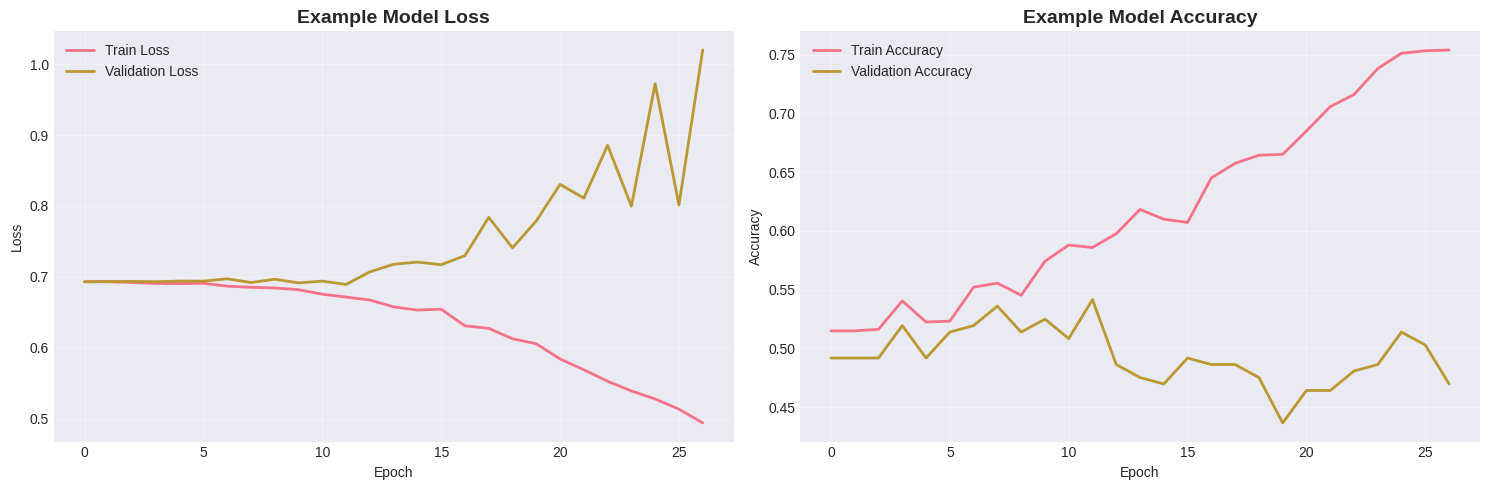

In [ ]:
# 학습 과정 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(example_history["train_loss"], label="Train Loss", linewidth=2)
axes[0].plot(example_history["val_loss"], label="Validation Loss", linewidth=2)
axes[0].set_title("Example Model Loss", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(example_history["train_acc"], label="Train Accuracy", linewidth=2)
axes[1].plot(example_history["val_acc"], label="Validation Accuracy", linewidth=2)
axes[1].set_title("Example Model Accuracy", fontsize=14, fontweight="bold")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [56]:
from utils import predict_pytorch_model, evaluate_model
# predict_pytorch_model 함수는 (예측 확률, 이진 예측)을 반환합니다.

# 1. 테스트 데이터에 대한 예측 생성
y_pred_lstm_test_prob, y_pred_lstm_test = predict_pytorch_model(example_model, test_loader)

# 2. 정밀도 계산 함수 실행 (이제 y_pred_cnn_test가 정의되었습니다)
lstm_results_test = evaluate_model(y_test_seq, y_pred_lstm_test, "LSTM - Test")

# 1. 테스트 데이터에 대한 예측 생성
y_pred_gru_test_prob, y_pred_gru_test = predict_pytorch_model(gru_model, test_loader)

# 2. 정밀도 계산 함수 실행 (이제 y_pred_cnn_test가 정의되었습니다)
cnn_results_test = evaluate_model(y_test_seq, y_pred_gru_test, "GRU - Test")


# 1. 테스트 데이터에 대한 예측 생성
y_pred_cnn_test_prob, y_pred_cnn_test = predict_pytorch_model(cnn_model, test_loader)

# 2. 정밀도 계산 함수 실행 (이제 y_pred_cnn_test가 정의되었습니다)
cnn_results_test = evaluate_model(y_test_seq, y_pred_cnn_test, "CNN+LSTM - Test")

# 1. 테스트 데이터에 대한 예측 생성
y_pred_attention_test_prob, y_pred_attention_test = predict_pytorch_model(cnn_lstm_attention_model, test_loader)

# 2. 정밀도 계산 함수 실행 (이제 y_pred_cnn_test가 정의되었습니다)
attention_results_test = evaluate_model(y_test_seq, y_pred_attention_test, "ATTENTION - Test")


LSTM - Test 성능 평가
정확도 (Accuracy):  0.4987
정밀도 (Precision): 0.5000
재현율 (Recall):    0.2071
F1 Score:          0.2929


GRU - Test 성능 평가
정확도 (Accuracy):  0.4937
정밀도 (Precision): 0.4973
재현율 (Recall):    0.9343
F1 Score:          0.6491


CNN+LSTM - Test 성능 평가
정확도 (Accuracy):  0.5063
정밀도 (Precision): 0.5072
재현율 (Recall):    0.5354
F1 Score:          0.5209


ATTENTION - Test 성능 평가
정확도 (Accuracy):  0.5038
정밀도 (Precision): 0.5200
재현율 (Recall):    0.1313
F1 Score:          0.2097



## 3. 트레이딩 전략: 확률 기반 포지션 조절

예측 확률에 따라 투자 비율을 조절하는 전략입니다.

In [58]:
# 예측 함수 (확률 포함)
def predict_with_probability(model, data_loader):
    """
    모델 예측 및 확률 반환
    """
    model.eval()
    predictions_prob = []

    with torch.no_grad():
        for batch_X, _ in data_loader:
            batch_X = batch_X.to(device)
            outputs = model(batch_X)
            predictions_prob.append(outputs.cpu().numpy())

    predictions_prob = np.vstack(predictions_prob).flatten()
    predictions = (predictions_prob > 0.5).astype(int)

    return predictions_prob, predictions

# 예제 모델 예측
example_prob, example_pred = predict_with_probability(example_model, test_loader)

print(f"예측 완료!")
print(f"예측 수: {len(example_pred)}")
print(f"상승 예측: {np.sum(example_pred == 1)}개")
print(f"하락 예측: {np.sum(example_pred == 0)}개")
print(f"\n평균 상승 확률: {example_prob.mean():.2%}")

예측 완료!
예측 수: 395
상승 예측: 82개
하락 예측: 313개

평균 상승 확률: 42.77%


In [69]:
# 예측 함수2 (확률 포함)
def predict_with_probability(model, data_loader):
    """
    모델 예측 및 확률 반환
    """
    model.eval()
    predictions_prob = []

    with torch.no_grad():
        for batch_X, _ in data_loader:
            batch_X = batch_X.to(device)
            outputs = model(batch_X)
            predictions_prob.append(outputs.cpu().numpy())

    predictions_prob = np.vstack(predictions_prob).flatten()
    predictions = (predictions_prob > 0.5).astype(int)

    return predictions_prob, predictions

# 예제 모델 예측
example_prob, example_pred = predict_with_probability(cnn_lstm_attention_model, test_loader)

print(f"예측 완료!")
print(f"예측 수: {len(example_pred)}")
print(f"상승 예측: {np.sum(example_pred == 1)}개")
print(f"하락 예측: {np.sum(example_pred == 0)}개")
print(f"\n평균 상승 확률: {example_prob.mean():.2%}")

예측 완료!
예측 수: 395
상승 예측: 50개
하락 예측: 345개

평균 상승 확률: 44.77%


In [95]:
# 확률 기반 트레이딩 전략(손실방지 함수 추가)
def simulate_probability_trading(predictions_prob, actual_prices, dates,
                                 initial_capital=10000, transaction_fee=0.001,
                                 threshold=0.5, position_scaling=True, stop_loss_rate=0.03,
                                 rsi_values=None):
    """
    확률 기반 트레이딩 시뮬레이션

    Parameters:
    -----------
    predictions_prob : array
        상승 확률 (0~1)
    actual_prices : array
        실제 가격
    dates : array
        날짜
    initial_capital : float
        초기 자본
    transaction_fee : float
        거래 수수료
    threshold : float
        매수 결정 임계값 (기본 0.5)
    position_scaling : bool
        True: 확률에 비례하여 투자 비율 조절
        False: 임계값 초과 시 전액 투자
    """
    cash = initial_capital
    btc_holdings = 0
    portfolio_values = []
    trade_log = []
    entry_price = 0.0

    for i in range(len(predictions_prob)):
        current_price = actual_prices[i]
        prob = predictions_prob[i]

        portfolio_value = cash + btc_holdings * current_price
        portfolio_values.append(portfolio_value)

        # 마지막 날 전량 매도
        if i == len(predictions_prob) - 1:
            if btc_holdings > 0:
                sell_value = btc_holdings * current_price * (1 - transaction_fee)
                trade_log.append({
                    'date': dates[i],
                    'action': 'SELL_ALL',
                    'price': current_price,
                    'prob': prob,
                    'amount': btc_holdings,
                    'value': btc_holdings * current_price,
                    'fee': btc_holdings * current_price * transaction_fee
                })
                cash += sell_value
                btc_holdings = 0
            continue

        if btc_holdings > 0 and stop_loss_rate is not None:
            stop_loss_price = entry_price * (1 - stop_loss_rate)
            if current_price < stop_loss_price:
                sell_value = btc_holdings * current_price * (1 - transaction_fee)

                trade_log.append({
                    'date': dates[i],
                    'action': 'STOP_LOSS',
                    'price': current_price,
                    'prob': prob,
                    'amount': btc_holdings,
                    'value': btc_holdings * current_price,
                    'fee': btc_holdings * current_price * transaction_fee
                })

                cash += sell_value
                btc_holdings = 0
                entry_price = 0.0

                continue


        # 투자 비율 결정
        if position_scaling:
            # 확률 기반 포지션 조절
            if prob > threshold:
                # 확률에 비례하여 투자 (예: 70% 확률 → 40% 투자)
                invest_ratio = prob
            else:
                # 임계값 미만이면 매도 또는 관망
                invest_ratio = 0
        else:
            # 단순 전략: 임계값 초과 시 전액 투자
            invest_ratio = 1.0 if prob > threshold else 0.0

        if rsi_values is not None:
            rsi_multiplier = 1.0 # 기본 승수

            # 현재 날짜 i의 RSI 값 사용
            current_rsi = rsi_values[i]

            if current_rsi > 90:  # 과매수
                rsi_multiplier = 0.5  # 투자 비율 절반으로 축소
            elif current_rsi < 35:  # 과매도
                rsi_multiplier = 1.5  # 투자 비율 1.5배로 확대

            # 기존 invest_ratio에 승수 적용
            invest_ratio = invest_ratio * rsi_multiplier

            # 투자 비율이 1.0을 초과하지 않도록 안전 장치 추가
            invest_ratio = min(invest_ratio, 1.0)

        # 현재 포지션 비율
        current_position_ratio = (btc_holdings * current_price) / portfolio_value if portfolio_value > 0 else 0

        # 포지션 조정
        target_btc_value = portfolio_value * invest_ratio
        current_btc_value = btc_holdings * current_price

        if target_btc_value > current_btc_value:  # 매수 필요
            buy_cash = target_btc_value - current_btc_value
            if buy_cash > cash:
                buy_cash = cash
            if buy_cash > 0:
                buy_amount = (buy_cash * (1 - transaction_fee)) / current_price
                old_btc_holdings = btc_holdings
                btc_holdings += buy_amount

                trade_log.append({
                    'date': dates[i],
                    'action': 'BUY',
                    'price': current_price,
                    'prob': prob,
                    'amount': buy_amount,
                    'value': buy_cash,
                    'fee': buy_cash * transaction_fee
                })

                old_cost_basis = btc_holdings * entry_price
                new_cost_basis = old_cost_basis + buy_cash

                entry_price = new_cost_basis / btc_holdings
                cash -= buy_cash

        elif target_btc_value < current_btc_value:  # 매도 필요
            sell_btc = (current_btc_value - target_btc_value) / current_price
            if sell_btc > btc_holdings:
                sell_btc = btc_holdings
            if sell_btc > 0:
                sell_value = sell_btc * current_price * (1 - transaction_fee)
                trade_log.append({
                    'date': dates[i],
                    'action': 'SELL',
                    'price': current_price,
                    'prob': prob,
                    'amount': sell_btc,
                    'value': sell_btc * current_price,
                    'fee': sell_btc * current_price * transaction_fee
                })
                cash += sell_value
                btc_holdings -= sell_btc

    final_value = portfolio_values[-1]
    total_return = (final_value - initial_capital) / initial_capital * 100

    total_trade_volume = sum(trade['value'] for trade in trade_log)
    total_fees_paid = sum(trade['fee'] for trade in trade_log)

    return {
        'initial_capital': initial_capital,
        'final_value': final_value,
        'total_return': total_return,
        'portfolio_values': portfolio_values,
        'trade_log': trade_log,
        'num_trades': len(trade_log),
        'total_trade_volume': total_trade_volume,
        'total_fees_paid': total_fees_paid
    }

print("✅ 트레이딩 시뮬레이션 함수 준비 완료!")

✅ 트레이딩 시뮬레이션 함수 준비 완료!


In [ ]:
# 확률 기반 트레이딩 전략
def simulate_probability_trading(predictions_prob, actual_prices, dates,
                                 initial_capital=10000, transaction_fee=0.001,
                                 threshold=0.5, position_scaling=True):
    """
    확률 기반 트레이딩 시뮬레이션

    Parameters:
    -----------
    predictions_prob : array
        상승 확률 (0~1)
    actual_prices : array
        실제 가격
    dates : array
        날짜
    initial_capital : float
        초기 자본
    transaction_fee : float
        거래 수수료
    threshold : float
        매수 결정 임계값 (기본 0.5)
    position_scaling : bool
        True: 확률에 비례하여 투자 비율 조절
        False: 임계값 초과 시 전액 투자
    """
    cash = initial_capital
    btc_holdings = 0
    portfolio_values = []
    trade_log = []

    for i in range(len(predictions_prob)):
        current_price = actual_prices[i]
        prob = predictions_prob[i]

        portfolio_value = cash + btc_holdings * current_price
        portfolio_values.append(portfolio_value)

        # 마지막 날 전량 매도
        if i == len(predictions_prob) - 1:
            if btc_holdings > 0:
                sell_value = btc_holdings * current_price * (1 - transaction_fee)
                trade_log.append({
                    'date': dates[i],
                    'action': 'SELL_ALL',
                    'price': current_price,
                    'prob': prob,
                    'amount': btc_holdings,
                    'value': btc_holdings * current_price,
                    'fee': btc_holdings * current_price * transaction_fee
                })
                cash += sell_value
                btc_holdings = 0
            continue

        # 투자 비율 결정
        if position_scaling:
            # 확률 기반 포지션 조절
            if prob > threshold:
                # 확률에 비례하여 투자 (예: 70% 확률 → 70% 투자)
                invest_ratio = prob
            else:
                # 임계값 미만이면 매도 또는 관망
                invest_ratio = 0
        else:
            # 단순 전략: 임계값 초과 시 전액 투자
            invest_ratio = 1.0 if prob > threshold else 0.0

        # 현재 포지션 비율
        current_position_ratio = (btc_holdings * current_price) / portfolio_value if portfolio_value > 0 else 0

        # 포지션 조정
        target_btc_value = portfolio_value * invest_ratio
        current_btc_value = btc_holdings * current_price

        if target_btc_value > current_btc_value:  # 매수 필요
            buy_cash = target_btc_value - current_btc_value
            if buy_cash > cash:
                buy_cash = cash
            if buy_cash > 0:
                buy_amount = (buy_cash * (1 - transaction_fee)) / current_price
                btc_holdings += buy_amount
                trade_log.append({
                    'date': dates[i],
                    'action': 'BUY',
                    'price': current_price,
                    'prob': prob,
                    'amount': buy_amount,
                    'value': buy_cash,
                    'fee': buy_cash * transaction_fee
                })
                cash -= buy_cash
        elif target_btc_value < current_btc_value:  # 매도 필요
            sell_btc = (current_btc_value - target_btc_value) / current_price
            if sell_btc > btc_holdings:
                sell_btc = btc_holdings
            if sell_btc > 0:
                sell_value = sell_btc * current_price * (1 - transaction_fee)
                trade_log.append({
                    'date': dates[i],
                    'action': 'SELL',
                    'price': current_price,
                    'prob': prob,
                    'amount': sell_btc,
                    'value': sell_btc * current_price,
                    'fee': sell_btc * current_price * transaction_fee
                })
                cash += sell_value
                btc_holdings -= sell_btc

    final_value = portfolio_values[-1]
    total_return = (final_value - initial_capital) / initial_capital * 100

    total_trade_volume = sum(trade['value'] for trade in trade_log)
    total_fees_paid = sum(trade['fee'] for trade in trade_log)

    return {
        'initial_capital': initial_capital,
        'final_value': final_value,
        'total_return': total_return,
        'portfolio_values': portfolio_values,
        'trade_log': trade_log,
        'num_trades': len(trade_log),
        'total_trade_volume': total_trade_volume,
        'total_fees_paid': total_fees_paid
    }

print("✅ 트레이딩 시뮬레이션 함수 준비 완료!")

✅ 트레이딩 시뮬레이션 함수 준비 완료!


In [71]:
# 테스트 데이터 준비
test_start_idx = len(btc_features) - len(y_test) + sequence_length
test_prices_aligned = btc_features["Close"].iloc[test_start_idx:test_start_idx+len(y_test_seq)].squeeze().values
test_dates_aligned = btc_features.index[test_start_idx:test_start_idx+len(y_test_seq)]

print(f"테스트 기간: {test_dates_aligned[0]} ~ {test_dates_aligned[-1]}")
print(f"테스트 샘플 수: {len(test_prices_aligned)}")

테스트 기간: 2024-11-07 00:00:00 ~ 2025-12-06 00:00:00
테스트 샘플 수: 395


## 4. 예제 전략 실행 및 결과

두 가지 예제 전략을 비교합니다:
1. **확률 기반 전략**: 예측 확률에 비례하여 투자 비율 조절
2. **단순 전략**: 50% 이상이면 전액 투자

In [96]:
# 예제 전략 1: 확률 기반 포지션 조절
example_result_prob = simulate_probability_trading(
    predictions_prob=example_prob,
    actual_prices=test_prices_aligned,
    dates=test_dates_aligned,
    initial_capital=10000,
    transaction_fee=0.001,
    threshold=0.53, # 53% 이상 확신할 때만 거래 (보수적),
    position_scaling=True, # 확률 비례 투자
    stop_loss_rate=0.03, # 3% 손실 시 매도
    rsi_values=btc_features['RSI_14'].iloc[test_start_idx:].values
)

print("="*70)
print("예제 전략 1: 확률 기반 포지션 조절")
print("="*70)
print(f"초기 자본: ${example_result_prob['initial_capital']:,.2f}")
print(f"최종 자본: ${example_result_prob['final_value']:,.2f}")
print(f"수익률: {example_result_prob['total_return']:.2f}%")
print(f"거래 횟수: {example_result_prob['num_trades']}회")
print(f"총 수수료: ${example_result_prob['total_fees_paid']:,.2f}")
print("="*70)

예제 전략 1: 확률 기반 포지션 조절
초기 자본: $10,000.00
최종 자본: $11,111.78
수익률: 11.12%
거래 횟수: 25회
총 수수료: $85.02


In [98]:
# 예제 전략 2: 단순 전략 (전액 투자)
example_result_simple = simulate_probability_trading(
    predictions_prob=example_prob,
    actual_prices=test_prices_aligned,
    dates=test_dates_aligned,
    initial_capital=10000,
    transaction_fee=0.001,
    threshold=0.7 , # 70% 이상 확신할 때만 전액 투자 (매우 보수적),
    position_scaling=False  # 전액 투자
)

print("="*70)
print("예제 전략 2: 단순 전략 (50% 이상 시 전액 투자)")
print("="*70)
print(f"초기 자본: ${example_result_simple['initial_capital']:,.2f}")
print(f"최종 자본: ${example_result_simple['final_value']:,.2f}")
print(f"수익률: {example_result_simple['total_return']:.2f}%")
print(f"거래 횟수: {example_result_simple['num_trades']}회")
print(f"총 수수료: ${example_result_simple['total_fees_paid']:,.2f}")
print("="*70)

예제 전략 2: 단순 전략 (50% 이상 시 전액 투자)
초기 자본: $10,000.00
최종 자본: $10,000.00
수익률: 0.00%
거래 횟수: 0회
총 수수료: $0.00


In [99]:
# Buy and Hold 벤치마크
initial_price = test_prices_aligned[0]
coins_bought = (10000 * (1 - 0.001)) / initial_price
buy_hold_final_value = coins_bought * test_prices_aligned[-1] * (1 - 0.001)
buy_hold_return = (buy_hold_final_value - 10000) / 10000 * 100
buy_hold_portfolio = [coins_bought * price for price in test_prices_aligned]

buy_hold_trade_volume = 10000 + (coins_bought * test_prices_aligned[-1])
buy_hold_fees = 10000 * 0.001 + (coins_bought * test_prices_aligned[-1]) * 0.001

print("="*70)
print("Buy and Hold 벤치마크")
print("="*70)
print(f"시작 가격: ${initial_price:,.2f}")
print(f"종료 가격: ${test_prices_aligned[-1]:,.2f}")
print(f"초기 자본: $10,000.00")
print(f"최종 자본: ${buy_hold_final_value:,.2f}")
print(f"수익률: {buy_hold_return:.2f}%")
print(f"거래 횟수: 2회")
print(f"총 수수료: ${buy_hold_fees:,.2f}")
print("="*70)

Buy and Hold 벤치마크
시작 가격: $75,904.86
종료 가격: $89,272.38
초기 자본: $10,000.00
최종 자본: $11,737.58
수익률: 17.38%
거래 횟수: 2회
총 수수료: $21.75


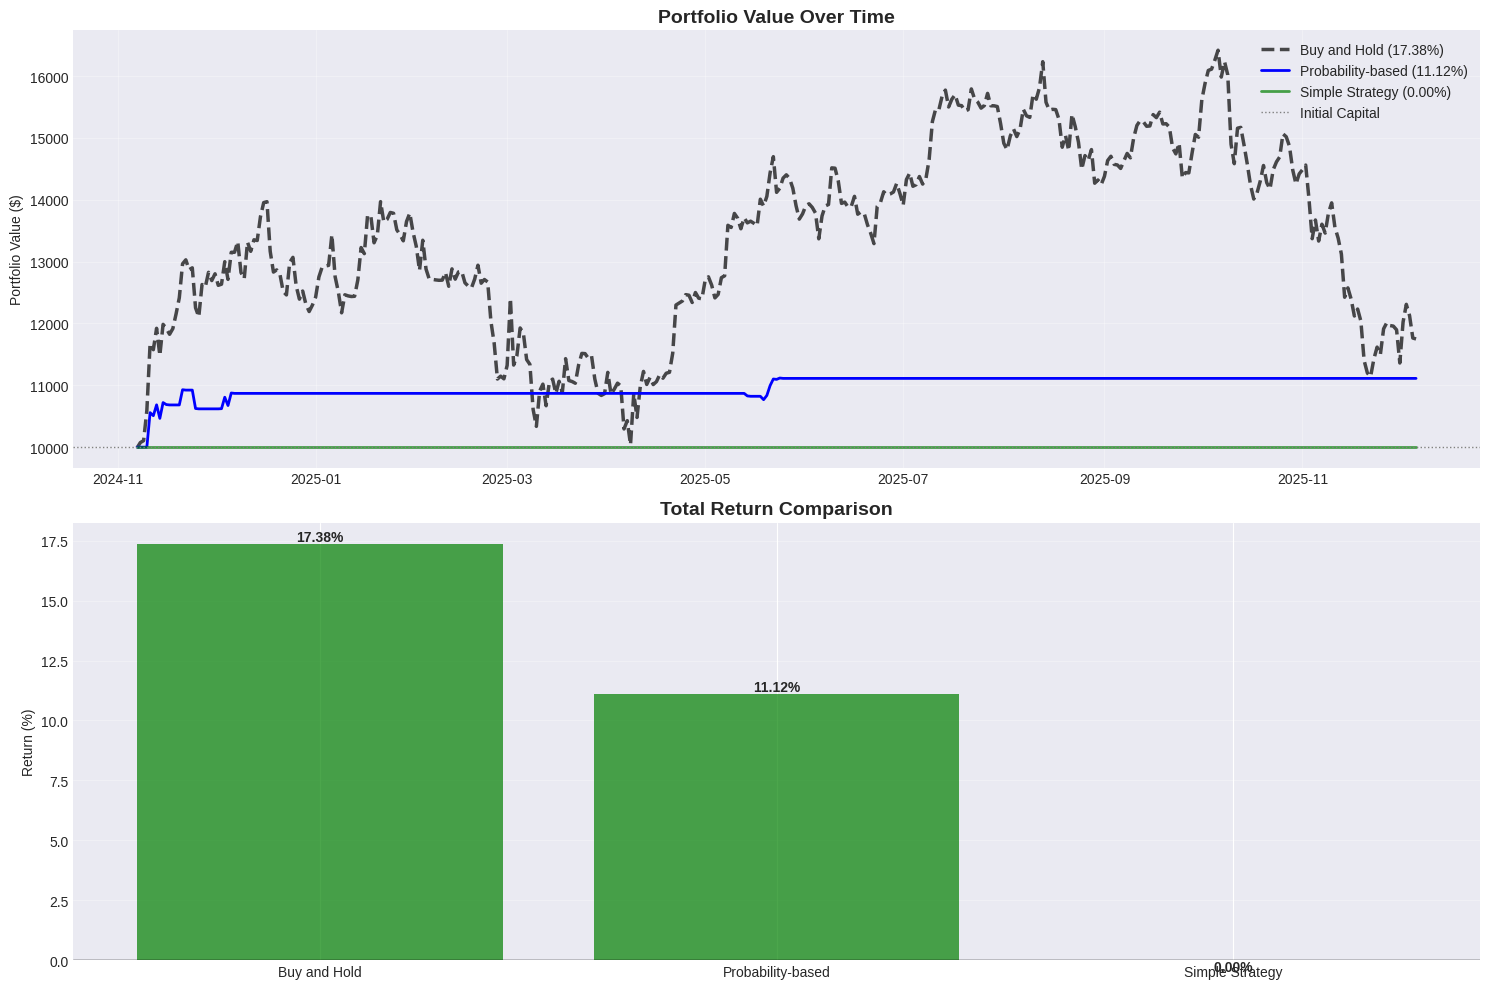

In [100]:
# 전략 비교 시각화
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# 포트폴리오 가치 변화
axes[0].plot(test_dates_aligned, buy_hold_portfolio,
            label=f"Buy and Hold ({buy_hold_return:.2f}%)",
            linewidth=2.5, linestyle="--", color="black", alpha=0.7)
axes[0].plot(test_dates_aligned, example_result_prob["portfolio_values"],
            label=f"Probability-based ({example_result_prob['total_return']:.2f}%)",
            linewidth=2, color="blue")
axes[0].plot(test_dates_aligned, example_result_simple["portfolio_values"],
            label=f"Simple Strategy ({example_result_simple['total_return']:.2f}%)",
            linewidth=2, color="green", alpha=0.7)
axes[0].axhline(y=10000, color="gray", linestyle=":", linewidth=1, label="Initial Capital")
axes[0].set_title("Portfolio Value Over Time", fontsize=14, fontweight="bold")
axes[0].set_ylabel("Portfolio Value ($)")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 수익률 비교
strategies = ["Buy and Hold", "Probability-based", "Simple Strategy"]
returns = [buy_hold_return, example_result_prob['total_return'], example_result_simple['total_return']]
colors = ['green' if r > 0 else 'red' for r in returns]

axes[1].bar(strategies, returns, color=colors, alpha=0.7)
axes[1].axhline(y=0, color="black", linestyle="-", linewidth=1)
axes[1].set_title("Total Return Comparison", fontsize=14, fontweight="bold")
axes[1].set_ylabel("Return (%)")
axes[1].grid(axis="y", alpha=0.3)

for i, (strategy, ret) in enumerate(zip(strategies, returns)):
    axes[1].text(i, ret, f'{ret:.2f}%', ha='center',
                va='bottom' if ret > 0 else 'top', fontweight='bold')

plt.tight_layout()
plt.show()

---

## 💡 과제 수행 가이드 (꼭 읽어보세요!)

### 🎯 과제 목표 재확인
**Buy and Hold 벤치마크를 초과하는 수익률 달성**

### 📝 추천 접근 방법 (난이도 순)

#### 레벨 1️⃣: 예제 전략 파라미터만 조정 (가장 쉬움)
위의 예제 코드를 **복사**해서 파라미터만 변경:

```python
# 예제 코드 복사 후 아래 값들만 변경해보세요!
my_result = simulate_probability_trading(
    predictions_prob=example_prob,  # 예제 모델 예측 사용
    actual_prices=test_prices_aligned,
    dates=test_dates_aligned,
    initial_capital=10000,
    transaction_fee=0.001,
    threshold=0.65,  # ← 이 값을 조정 (0.5~0.8 추천)
    position_scaling=True  # ← True/False 변경
)
```

**실험 아이디어:**
- `threshold=0.55`: 약간 공격적
- `threshold=0.65`: 중립적
- `threshold=0.75`: 보수적

#### 레벨 2️⃣: 전략 함수 수정 (중간)
`simulate_probability_trading` 함수를 복사해서 수정:

```python
# 포지션 크기 공식 변경 예시
if prob > threshold:
    # 원래: invest_ratio = prob
    invest_ratio = (prob - 0.5) * 2  # 50%를 기준으로 스케일링
    # 예: prob=0.7 → invest_ratio=0.4 (40% 투자)
```

#### 레벨 3️⃣: 모델 아키텍처 변경 (어려움)
`ExampleLSTMModel`을 복사해서 수정:

```python
class MyTradingModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, dropout=0.2):
        super(MyTradingModel, self).__init__()
        # LSTM → GRU로 변경
        self.gru1 = nn.GRU(input_size, hidden_size, batch_first=True)
        # 나머지는 동일하게...
```

#### 레벨 4️⃣: 복합 전략 (고급)
모델 예측 + 기술적 지표 결합:

```python
# RSI와 결합하는 예시
rsi_values = btc_features['RSI_14'].iloc[test_start_idx:].values

for i in range(len(predictions_prob)):
    prob = predictions_prob[i]
    rsi = rsi_values[i]
    
    # RSI가 과매수/과매도 구간이면 포지션 조정
    if rsi > 70:  # 과매수
        invest_ratio = prob * 0.5  # 투자 비율 절반으로
    elif rsi < 30:  # 과매도
        invest_ratio = min(prob * 1.5, 1.0)  # 투자 비율 증가
```

---

### ⚡ 빠른 시작 체크리스트

1. [ ] 위 예제 코드 실행 결과 확인
2. [ ] 레벨 1부터 시작: 예제 코드 복사 → 파라미터 변경
3. [ ] 여러 `threshold` 값 실험 (0.5, 0.6, 0.7, 0.8)
4. [ ] 가장 좋은 결과를 선택
5. [ ] 결과 분석 및 고찰 작성

### 💰 수익률 향상 팁

- **과도한 거래 줄이기**: `threshold` 높이기 (0.6~0.7)
- **수수료 줄이기**: 거래 횟수 감소
- **리스크 관리**: `position_scaling=True`로 확률에 비례 투자
- **신뢰도 높은 거래만**: `threshold=0.7` 이상

---

## 5. 자신만의 모델 및 전략 개발 ⭐

### 📝 개발 가이드

#### 1. 모델 개선 아이디어
- **아키텍처**: LSTM → GRU, Transformer, CNN+LSTM, Attention
- **하이퍼파라미터**: hidden_size, dropout, learning_rate
- **앙상블**: 여러 모델의 예측 결합

#### 2. 전략 개선 아이디어
- **임계값 조정**: threshold를 0.6 또는 0.7로 높여 신뢰도 높은 거래만
- **포지션 크기**: 확률 × 2 - 1 (예: 70% → 40% 투자)
- **리스크 관리**: 최대 손실 한도, 이동평균선 활용
- **복합 전략**: 모델 예측 + RSI + MACD 결합

---

**TODO: 아래에 자신의 모델 설계 설명을 작성하세요**

```
1. 모델 아키텍처:
   -

2. 선택 이유:
   -

3. 트레이딩 전략:
   -

4. 하이퍼파라미터:
   - hidden_size:
   - learning_rate:
   - threshold:
   - position_scaling:

5. 예제와의 차별점:
   -
```

In [ ]:
# TODO: 자신만의 모델 구현

class MyTradingModel(nn.Module):
    """
    TODO: 자신만의 트레이딩 모델 구현

    입력: (batch, sequence_length, features)
    출력: (batch, 1) - 상승 확률 (0~1)
    """
    def __init__(self, input_size, hidden_size=64, dropout=0.2):
        super(MyTradingModel, self).__init__()

        # TODO: 레이어 정의
        # 힌트: 예제 모델 코드를 복사해서 수정
        pass

    def forward(self, x):
        # TODO: Forward pass 구현
        pass

# TODO: 모델 생성 (주석 해제 후 사용)
# my_model = MyTradingModel(
#     input_size=X_train_seq.shape[2],
#     hidden_size=64,
#     dropout=0.2
# ).to(device)

# print("나의 모델 구조:")
# print(my_model)
# print(f"\nTotal parameters: {sum(p.numel() for p in my_model.parameters()):,}")

In [ ]:
# TODO: 모델 학습 (주석 해제 후 사용)

# print("나의 모델 학습 시작...")
# my_history = train_model(
#     model=my_model,
#     train_loader=train_loader,
#     val_loader=val_loader,
#     epochs=100,
#     lr=0.001,
#     patience=15
# )
# print("\n✅ 모델 학습 완료!")

In [ ]:
# TODO: 학습 과정 시각화 (선택사항)

# fig, axes = plt.subplots(1, 2, figsize=(15, 5))
# axes[0].plot(my_history["train_loss"], label="Train Loss", linewidth=2)
# axes[0].plot(my_history["val_loss"], label="Validation Loss", linewidth=2)
# axes[0].set_title("My Model Loss", fontsize=14, fontweight="bold")
# axes[0].set_xlabel("Epoch")
# axes[0].set_ylabel("Loss")
# axes[0].legend()
# axes[0].grid(True, alpha=0.3)
# axes[1].plot(my_history["train_acc"], label="Train Accuracy", linewidth=2)
# axes[1].plot(my_history["val_acc"], label="Validation Accuracy", linewidth=2)
# axes[1].set_title("My Model Accuracy", fontsize=14, fontweight="bold")
# axes[1].set_xlabel("Epoch")
# axes[1].set_ylabel("Accuracy")
# axes[1].legend()
# axes[1].grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()

In [ ]:
# TODO: 예측 및 트레이딩 시뮬레이션 (주석 해제 후 사용)

# # 예측
# my_prob, my_pred = predict_with_probability(my_model, test_loader)

# # 트레이딩 시뮬레이션
# my_result = simulate_probability_trading(
#     predictions_prob=my_prob,
#     actual_prices=test_prices_aligned,
#     dates=test_dates_aligned,
#     initial_capital=10000,
#     transaction_fee=0.001,
#     threshold=0.5,  # TODO: 조정 가능
#     position_scaling=True  # TODO: True/False 선택
# )

# print("="*70)
# print("나의 트레이딩 전략 결과")
# print("="*70)
# print(f"초기 자본: ${my_result['initial_capital']:,.2f}")
# print(f"최종 자본: ${my_result['final_value']:,.2f}")
# print(f"수익률: {my_result['total_return']:.2f}%")
# print(f"Buy and Hold 대비: {my_result['total_return'] - buy_hold_return:.2f}%p")
# print(f"거래 횟수: {my_result['num_trades']}회")
# print(f"총 수수료: ${my_result['total_fees_paid']:,.2f}")
# print("="*70)

In [ ]:
# TODO: 최종 결과 비교 (주석 해제 후 사용)

# fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# # 포트폴리오 가치
# axes[0].plot(test_dates_aligned, buy_hold_portfolio,
#             label=f"Buy and Hold ({buy_hold_return:.2f}%)",
#             linewidth=2.5, linestyle="--", color="black", alpha=0.7)
# axes[0].plot(test_dates_aligned, example_result_prob["portfolio_values"],
#             label=f"Example Model ({example_result_prob['total_return']:.2f}%)",
#             linewidth=2, color="blue", alpha=0.7)
# axes[0].plot(test_dates_aligned, my_result["portfolio_values"],
#             label=f"My Model ({my_result['total_return']:.2f}%)",
#             linewidth=2, color="red")
# axes[0].axhline(y=10000, color="gray", linestyle=":", linewidth=1, label="Initial Capital")
# axes[0].set_title("Portfolio Value Over Time", fontsize=14, fontweight="bold")
# axes[0].set_ylabel("Portfolio Value ($)")
# axes[0].legend()
# axes[0].grid(True, alpha=0.3)

# # 수익률 비교
# strategies = ["Buy and Hold", "Example Model", "My Model"]
# returns = [buy_hold_return, example_result_prob['total_return'], my_result['total_return']]
# colors = ['green' if r > 0 else 'red' for r in returns]

# axes[1].bar(strategies, returns, color=colors, alpha=0.7)
# axes[1].axhline(y=0, color="black", linestyle="-", linewidth=1)
# axes[1].set_title("Total Return Comparison", fontsize=14, fontweight="bold")
# axes[1].set_ylabel("Return (%)")
# axes[1].grid(axis="y", alpha=0.3)

# for i, (strategy, ret) in enumerate(zip(strategies, returns)):
#     axes[1].text(i, ret, f'{ret:.2f}%', ha='center',
#                 va='bottom' if ret > 0 else 'top', fontweight='bold')

# plt.tight_layout()
# plt.show()

## 6. 결과 분석 및 고찰 📊

### ✍️ 답변 작성

**1. 모델 성능 분석**

```
- Buy and Hold 대비 수익률:
- 모델 예측 정확도:
- 주요 성공/실패 시기:
```

**2. 트레이딩 전략 분석**

```
- 선택한 전략:
- 전략의 장단점:
- 수수료 영향:
```

**3. 모델 설계**

```
- 아키텍처 선택 이유:
- 하이퍼파라미터 튜닝:
- 예제 모델과의 차이점:
```

**4. 개선 방향**

```
- 모델의 한계점:
- 추가 실험 아이디어:
- 실전 적용 시 고려사항:
```

---

## ✅ 과제 체크리스트

- [ ] 학생 정보 (이름, 학번) 작성
- [ ] MyTradingModel 클래스 구현 완료
- [ ] 모델 학습 완료
- [ ] 트레이딩 전략 설계 및 시뮬레이션
- [ ] Buy and Hold와 비교 분석
- [ ] 결과 분석 및 고찰 작성
- [ ] 코드에 충분한 주석 추가

### 평가 기준

1. **수익률 (60%)** - Buy and Hold 벤치마크 대비 수익
2. **모델 & 전략 설계 (30%)** - 논리적 근거, 창의성
3. **코드 품질 (10%)** - 가독성, 주석, 설명

---

**과제를 완성하셨습니다! 수고하셨습니다! 🎉**